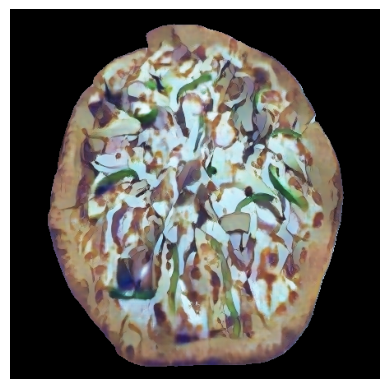

In [3]:
from models import Transformer
from models import pr_st,pr_ss
import torch
import torch.nn as nn
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import cv2 as cv
import models
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#img preprocessing
st_preprocessing = pr_st()
ss_preprocessing = pr_ss()
st_img = st_preprocessing.process('./pizza.jpg')
ss_img = ss_preprocessing.process()

#style transfer model initialization
st_model = Transformer()
st_model.load_state_dict(torch.load('./pretrained_model/Shinkai_net_G_float.pth'))
st_model.to(device)
st_model.eval()

#segment model initialization
sam = sam_model_registry['vit_h'](checkpoint='../segment/sam_vit_h_4b8939.pth').to(device=device) #pretrained weights
ss_model = SamAutomaticMaskGenerator(sam) #for no-prompt segment
predictor = SamPredictor(sam) #for pointed segment

#style transfered output
out = st_model(st_img) 
out = models.denormalize(out[0])[1:-1,1:-1,:]

#mask generation without prompt
mask = ss_model.generate(ss_img)[0]['segmentation']

#mask generation with desinated point 
input_points = np.array([[112,450-112],[112,112],[450-112,112],[450-112,450-112],[225,225]])
predictor.set_image(ss_img)
masks,_,_ = predictor.predict(np.array([[225,225]]),np.array([1]))
mask = np.asarray(masks,dtype=np.uint8).transpose(1,2,0)[:,:,[1,1,1]]

obj = out*mask
plt.imshow(obj)
plt.axis('off')
plt.show()

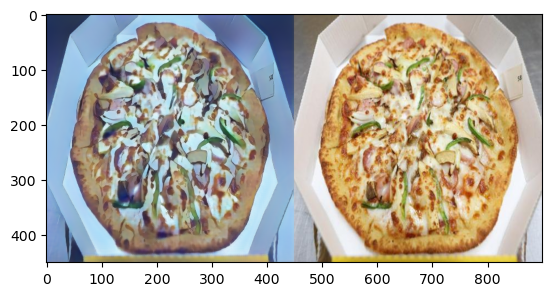

In [9]:
original = cv.imread('./resized.jpg')
original = cv.cvtColor(original,cv.COLOR_BGR2RGB)
plt.imshow(np.hstack((out,original/255)))

In [10]:
test = masks[:,:,0] == masks[:,:,1] 
diff =0
for i in range(450):
    for j in range(450):
        if test[i][j] == False:
            diff+=1
print(diff)

30153


149428

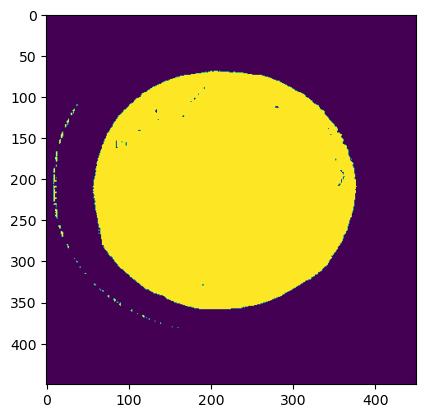

In [15]:
plt.imshow(masks[:,:,2]*255)

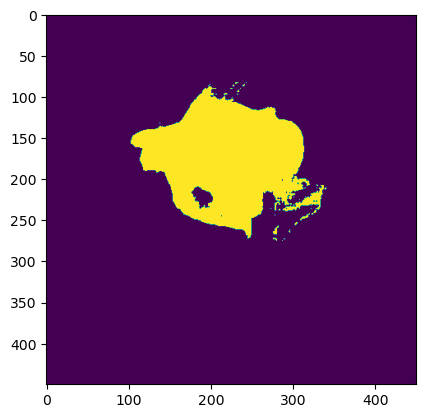

In [12]:
plt.imshow(masks[:,:,0]*255)

In [11]:
450*450

202500

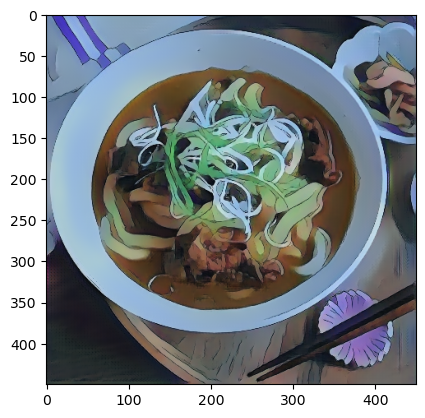

In [7]:
plt.imshow(out)

In [18]:
masks = np.asarray(masks,dtype=np.uint8).transpose(1,2,0)

In [19]:
masks.shape

(450, 450, 3)

In [21]:
cv.imshow('sms',ss_img*masks)

QObject::moveToThread: Current thread (0x81c5e50) is not the object's thread (0x93c423b0).
Cannot move to target thread (0x81c5e50)

QObject::moveToThread: Current thread (0x81c5e50) is not the object's thread (0x93c423b0).
Cannot move to target thread (0x81c5e50)

QObject::moveToThread: Current thread (0x81c5e50) is not the object's thread (0x93c423b0).
Cannot move to target thread (0x81c5e50)

QObject::moveToThread: Current thread (0x81c5e50) is not the object's thread (0x93c423b0).
Cannot move to target thread (0x81c5e50)

QObject::moveToThread: Current thread (0x81c5e50) is not the object's thread (0x93c423b0).
Cannot move to target thread (0x81c5e50)

QObject::moveToThread: Current thread (0x81c5e50) is not the object's thread (0x93c423b0).
Cannot move to target thread (0x81c5e50)

QObject::moveToThread: Current thread (0x81c5e50) is not the object's thread (0x93c423b0).
Cannot move to target thread (0x81c5e50)

QObject::moveToThread: Current thread (0x81c5e50) is not the object's

: 

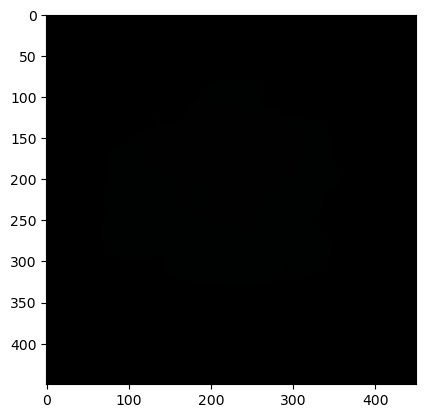

In [10]:
plt.imshow(masks)

In [ ]:
ssed = models.segment(ss_img,mask)
cv.imshow('segmented',ssed)
cv.waitKey(0)
cv.destroyAllWindows()

In [17]:
batch_size=16
learning_rate = 2*10e-4
#first, train the generator only 100 epochs
#for every 100 epochs stop and manually control the hyper parameters

In [18]:
class block(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super(block,self).__init__()
        self.in_channels=  in_channels
        self.out_channels= out_channels
        self.stride=stride
        self.conv = nn.Conv2d(in_channels = self.in_channels,out_channels=self.out_channels,stride=stride,kernel_size= 3,padding='same')
        self.activation = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels = self.in_channels,out_channels=self.out_channels,stride=stride,kernel_size= 3,padding='same')
    def forward(self,x):
        residual = x.clone()
        out = self.conv(x)
        out = self.activation(out)
        out = self.conv2(out)
        return out+residual
        
        

In [8]:
test = torch.tensor(np.zeros((3,256,256)),dtype=torch.float32).unsqueeze(0)

In [54]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.relu = nn.LeakyReLU()
        self.cv1 = nn.Conv2d(in_channels = 3, out_channels=32,kernel_size= 7,stride=1,padding='same' )
        self.cv2 = nn.Conv2d(in_channels = 32, out_channels=32, kernel_size=3,stride=2, padding=1)
        self.cv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1,padding='same')
        self.cv4 = nn.Conv2d(in_channels = 64, out_channels=64, kernel_size=3,stride=2,padding=1)
        self.cv5 = nn.Conv2d(in_channels= 64,out_channels=128,kernel_size=3,stride=1,padding='same')
        self.block1 = block(in_channels=128,out_channels=128)
        self.block2 = block(in_channels=128,out_channels=128)
        self.block3 = block(in_channels=128,out_channels=128)
        self.block4 = block(in_channels=128,out_channels=128)
        self.cv6 = nn.Conv2d(in_channels=128,out_channels=128,stride=1,kernel_size=3,padding='same')
        self.cv7 = nn.Conv2d(in_channels = 128+64, out_channels =64, kernel_size= 3,padding ='same',stride=1)
        self.cv8 = nn.Conv2d(in_channels = 64, out_channels = 64,kernel_size=3, padding='same',stride=1)
        self.cv9= nn.Conv2d(in_channels = 96, out_channels = 64, kernel_size=3, padding='same', stride=1)
        self.cv10 = nn.Conv2d(in_channels = 64, kernel_size=7, out_channels=3, padding='same',stride=1 )
    def forward(self,x):
        out = self.relu(self.cv1(x))
        residual1= out.clone()
        out = self.relu(self.cv2(out))
        out = self.relu(self.cv3(out))
        residual2 = out.clone()
        out = self.relu(self.cv4(out))
        out = self.relu(self.cv5(out))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.relu(self.cv6(out))
        out = F.interpolate(out, scale_factor=2,mode='bilinear',align_corners=False)
        out = out.view(-1,128,128,128)
        out =torch.concat((out,residual2),dim=1)
        out = self.relu(self.cv7(out))
        out = self.relu(self.cv8(out))
        out = F.interpolate(out, scale_factor=2,mode='bilinear',align_corners=False)
        out =torch.concat((out,residual1),dim=1)
        out = self.relu(self.cv9(out))
        out = self.cv10(out)
        return out

In [55]:
gen = Generator()
gen_opt = torch.optim.Adam(params=gen.parameters(),lr=learning_rate)

tensor([[[[ 0.0077,  0.0095,  0.0129,  ...,  0.0095,  0.0087,  0.0060],
          [ 0.0083,  0.0109,  0.0143,  ...,  0.0082,  0.0080,  0.0045],
          [ 0.0074,  0.0119,  0.0177,  ...,  0.0123,  0.0115,  0.0072],
          ...,
          [ 0.0093,  0.0133,  0.0202,  ...,  0.0145,  0.0113,  0.0071],
          [ 0.0094,  0.0135,  0.0198,  ...,  0.0136,  0.0108,  0.0072],
          [ 0.0090,  0.0113,  0.0142,  ...,  0.0084,  0.0049,  0.0015]],

         [[-0.0274, -0.0309, -0.0352,  ..., -0.0375, -0.0342, -0.0296],
          [-0.0289, -0.0355, -0.0392,  ..., -0.0425, -0.0395, -0.0332],
          [-0.0283, -0.0339, -0.0394,  ..., -0.0426, -0.0389, -0.0350],
          ...,
          [-0.0171, -0.0191, -0.0233,  ..., -0.0255, -0.0249, -0.0238],
          [-0.0134, -0.0180, -0.0202,  ..., -0.0220, -0.0242, -0.0244],
          [-0.0102, -0.0159, -0.0200,  ..., -0.0240, -0.0257, -0.0263]],

         [[ 0.0211,  0.0197,  0.0164,  ...,  0.0181,  0.0198,  0.0188],
          [ 0.0154,  0.0131,  

In [2]:
!pip3 install segmentation_models_pytorch

     -------------------------------------- 106.7/106.7 kB 6.0 MB/s eta 0:00:00
     ---------------------------------------- 58.8/58.8 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     ---------------------------------------- 77.1/77.1 kB 4.5 MB/s eta 0:00:00
     ------------------------------------- 236.8/236.8 kB 14.2 MB/s eta 0:00:00
     -------------------------------------- 263.9/263.9 kB 7.9 MB/s eta 0:00:00
     ------------------------------------- 163.8/163.8 kB 10.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16465 sha256=59f7864cc58c796c83332f5953ec1ab8cceb9b7453fda5aab21644c71f8bf939
  Stored in directory: c:\users\서민재\appdata\local\pip\cache\wheels